https://sbert.net/

In [ ]:
pip install -U sentence-transformers


In [ ]:
import pandas as pd
import numpy as np
import json
import torch
from pprint import pprint
from IPython.display import clear_output


In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


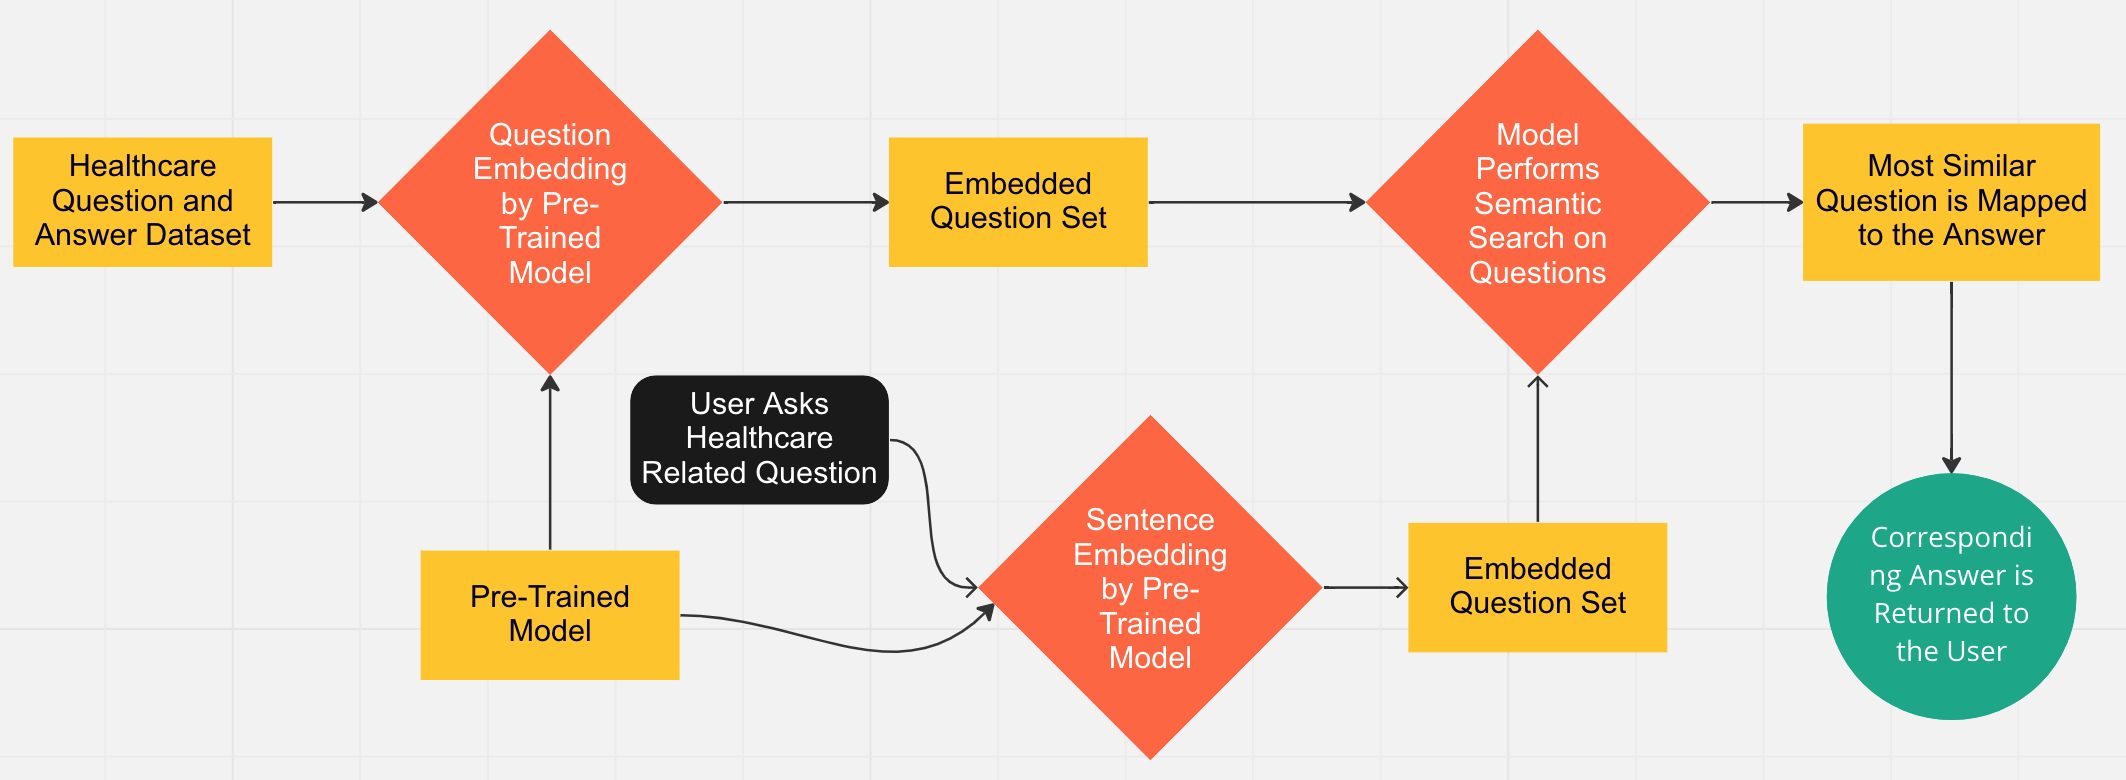

#### We read the medical question dataset with the question embeddings done in the pre-processing stage.

In [ ]:
link_to_dataset_on_drive = '/content/drive/MyDrive/Colab Notebooks/AI in Healthcare Project/health_dataset/df_health_ds.pkl'
df_health_ds = pd.read_pickle(link_to_dataset_on_drive)
df_health_ds.head()

,questions,answers,url,questions_embeddings
0,how do i stop smoking now,stopping smoking is about will power and being...,http://ehealthforum.com/health/stop-smoking-qu...,"[tensor(0.0626), tensor(0.0524), tensor(0.0028..."
1,i had a tubaligation 4 years ago and also have...,hello this sounds quite unfamiliar that due to...,http://ehealthforum.com/health/endometriosis-q...,"[tensor(0.0566), tensor(-0.0647), tensor(-0.02..."
2,could extra caffeine consumption be a cause of...,extra caffeine can cause gastric discomfort th...,http://ehealthforum.com/health/caffeine-consum...,"[tensor(0.0317), tensor(-0.0650), tensor(-0.02..."
3,"hello- i am a 24 year old female 5""4 & 115 lb ...",hello thanks for submitting your question here...,http://ehealthforum.com/health/pcos-one-ovary-...,"[tensor(-0.0734), tensor(-0.0055), tensor(-0.0..."
4,i was wanting to know if you could tell me if ...,i am glad to help you out. this is not possibl...,http://ehealthforum.com/health/not-knowing-you...,"[tensor(-0.0308), tensor(-0.0090), tensor(-0.0..."


#### Explore the dataset

In [ ]:
for index, row in df_health_ds.sample(5).iterrows():
  print("Q: ", row['questions'], '\n')
  print("A: ", row['answers'])
  print('===')

Q:  is there any treatment for chronic severe diarrhea after gall bladder removal? 

A:  diarrhea is troubling in 10% of people who have their gallbladders removed. the diarrhea is believed to be due to the fact that following removal of the gallbladder the intestines contain more bile acids than under normal conditions in which bile acids are stored for much of the day in the gallbladder. bile acids cause diarrhea by promoting the secretion of fluid by the intestines and perhaps by stimulating the intestinal muscles to contract. there are no good studies of treatment of this type of diarrhea but two treatments have been proposed and appear to be effective. the first are medications (for example cholestyramine) that attach to bile acids in the intestine and prevent them from interacting with the intestine. the second are fatty acid medications (for example oleic acid) that may act by slowing down the intestinal muscle and perhaps by reducing secretion of fluid although the exact mechan

In [ ]:
questions_embeddings = df_health_ds['questions_embeddings'].tolist()

#### The functionality of the system is as follows:  

    

* The user will input the question (or query). 

* The input will be sent to the sentence embedding to encode. 

* The encoded input is then compared with the dataset for the most similar question. 

* The answer to the most similar question is then returned to the user as the answer. 

### We used Semantic Search

Semantic search seeks to improve search accuracy by understanding the content of the search query. In contrast to traditional search engines which only find documents based on lexical matches, semantic search can also find synonyms.

The idea behind semantic search is to embed all entries in your corpus, whether they be sentences, paragraphs, or documents, into a vector space.

At search time, the query is embedded into the same vector space and the closest embeddings from your corpus are found. These entries should have a high semantic overlap with the query.

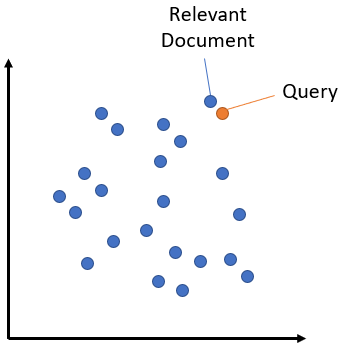

In [ ]:
def query(user_question, top_k = 1):
  user_question = user_question.strip()

  if user_question == '':
    return 'Please enter a valid question'

  user_embeddings = model.encode(user_question, convert_to_tensor=True)

  #Compute cosine-similarities for each sentence with each other sentence
  
  questions_embeddings = df_health_ds['questions_embeddings'].tolist()
  hits = util.semantic_search(user_embeddings, questions_embeddings, top_k=top_k)[0]

  similar_questions, similar_answer, score = [], [], []
  
  for hit in hits:
    
    the_id = hit['corpus_id']
    the_score = hit['score']
    
    similar_questions.append(df_health_ds['questions'].tolist()[the_id])
    ### Add question answering to shorten the answer
    similar_answer.append(df_health_ds['answers'].tolist()[the_id].replace('--> <link>', '') + ":::")
    score.append("(Score: {:.4f})".format(the_score))


  return similar_questions, similar_answer, score



In [ ]:

# user_question = 'what will be the reason for headache chest pain and dizziness?'
# user_question = 'How do I know if I am pregnant'
# user_question = 'Identify mental health'
user_question = 'What are signs of breast cancer'

similar_questions, similar_answer, similar_questions_score = query(user_question, top_k = 1)

pprint(similar_questions)
print()
pprint(similar_answer)
print()
pprint(similar_questions_score)

['lumps on breasts thoracic spine and shoulder blades sore could i have breast '
 'cancer?']

['symptoms that you are complaining of may or may not be signs and symptoms of '
 'breast cancer so you need to check with a specialist and get a mammogram as '
 'soon as you can as i said they may be carcinogenic lumps or just '
 'adenofibrosis due to some hormonal disorders:::']

['(Score: 0.6892)']


In [ ]:
exit_conditions = ['exit', 'quit', '']

### maybe add option to include related answers (goes in as top_k)
while True:
  clear_output(wait=True)
  user_query = input()
  if user_query.lower() in exit_conditions:
    print('Exiting ...')
    break

  answer_tuple = query(user_query, top_k = 1)
  for ans in answer_tuple:
    pprint(ans)
    print()


exit
Exiting ...
